In [55]:
import os
import logging
import numpy as np
import glob
import seaborn as sns
import pandas as pd
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from utils.dataset_helper import load_ag_news


os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['TZ'] = 'America/Chicago'
logger = logging.getLogger()
logger.setLevel(logging.INFO)
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

In [56]:
PATH = '/home/anneke/Documents/ann-mitchell-text-classification/dataset/ag_news_csv'

In [57]:
x_train, x_test, y_train, y_test = load_ag_news(PATH,
                                                  shuffle = True, 
                                                  lower = True, 
                                                  tokenize = False)

2019-09-05 21:08:46,986 INFO Shuffled.
2019-09-05 21:08:47,076 INFO Lowered.


In [58]:
type(x_train)

list

In [59]:
ind=np.array([0,1,6])

x_train[ind]

TypeError: only integer scalar arrays can be converted to a scalar index

In [60]:
[x_train[i] for i in ind]

['london - the british broadcasting corporation, the world #39;s biggest public broadcaster, is to cut almost a quarter of its 28 000-strong workforce, in the biggest shake-up in its 82-year history, the times newspaper in london said on monday.',
 'embattled insurance broker #39;s banks agree to waive clause that may have prevented access to credit. new york (reuters) - marsh  amp; mclennan cos.',
 'oil prices eased yesterday as top world exporter saudi arabia slashed prices for its westbound crude sales in an effort to shift the large volumes it is offering to cool world markets.']

In [61]:
print('Total training : {}'.format(len(x_train)))
print('Total testing : {}'.format(len(x_test)))

Total training : 120000
Total testing : 7600


In [62]:
LABEL = {1:'World', 2:'Sports', 3:'Business', 4:'Sci/Tech'}
def convert_label(l):
    return LABEL[l]

train_label = list(map(convert_label, y_train))

df = pd.DataFrame(train_label, columns=['label'])

In [73]:
ind = df[(df['label'] == 'Sports') | (df['label'] == 'Sci/Tech')].index.to_numpy()

In [74]:
train_len = [len(x_train[x]) for x in ind]
tl = pd.DataFrame(sorted(train_len), columns=['cnt'])

In [78]:
tl.shape

(60000, 1)

In [79]:
tl.describe()

,cnt
count,60000.000000
mean,189.511950
std,66.758469
min,20.000000
25%,150.000000
50%,182.000000
75%,214.000000
max,985.000000


In [75]:
m = tl.describe().loc[['50%']]['cnt']

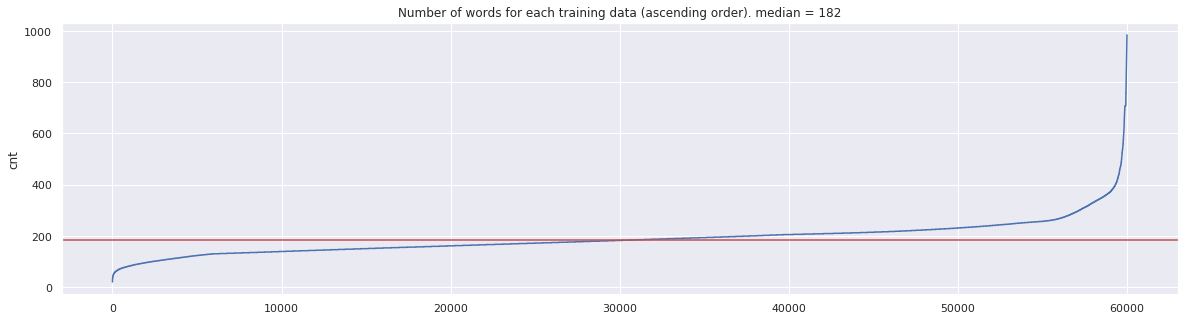

In [76]:
plt.figure(figsize=(20, 5))
plt.title('Number of words for each training data (ascending order). median = {}'.format(int(m)))
ax = sns.lineplot(x=tl.index, y="cnt", data=tl)
plt.axhline(y=float(m), color='r')
# plt.text(.5, .05, 'aaaaa', ha='center')

In [112]:
from collections import Counter

cnt = Counter()
# Count the number of unique words
for i in x_train:
    for j in i:
        cnt[j] += 1

In [117]:
len(cnt)

80555

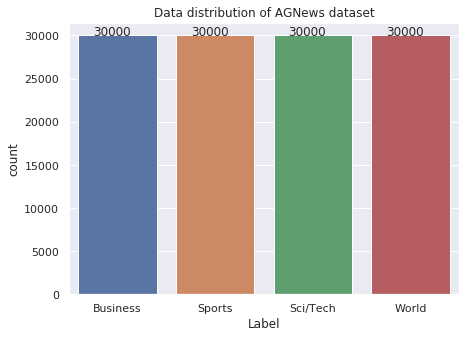

In [51]:
plt.figure(figsize=(7,5))
plt.title('Data distribution of AGNews dataset')
ax = sns.countplot(x="Label", data=df)

for p in ax.patches:
    ax.annotate('{:d}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

## Class, headline, content

1 World <br>
2 Sports <br>
3 Business <br>
4 Sci/Tech <br>
<br> <br>
The load function load label as {1,2,3,4}. <br>
We need to use one-hot vector

In [120]:
y_1_world = [1 if label == 1 else 0 for label in y_train]
y_2_sports = [1 if label == 2 else 0 for label in y_train]
y_3_buss = [1 if label == 3 else 0 for label in y_train]
y_4_scitech = [1 if label == 4 else 0 for label in y_train]

In [17]:
from utils import utils
import sklearn

In [31]:
x_tr = x_train[ind]
x_te = x_train[ind]

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
type(x_tr)

In [18]:
X_train, X_test, cv = utils.vectorize_keywords_docs(x_train, x_test, return_cv=True)

In [19]:
X_train['docs'].shape, X_test['docs'].shape

((120000, 4079), (7600, 4079))

In [22]:
X_train, X_test

({'docs': <120000x4079 sparse matrix of type '<class 'numpy.int64'>'
  	with 2971911 stored elements in Compressed Sparse Row format>},
 {'docs': <7600x4079 sparse matrix of type '<class 'numpy.int64'>'
  	with 187554 stored elements in Compressed Sparse Row format>})

In [23]:
ind = np.array(list(np.where(y_train==2)[0]) + list(np.where(y_train==4)[0]))

X_train['docs'] = X_train['docs'][ind]
y_train = y_train[ind]

y_train = [1 if y==4 else 0 for y in y_train]

In [24]:
X_train['docs'].shape, X_test['docs'].shape

((60000, 4079), (7600, 4079))

In [29]:
X_train['docs'].shape, X_test['docs'].shape

((60000, 4079), (7600, 4079))

In [144]:
np.unique(y_train)

array([0, 1])

In [180]:
clf = sklearn.linear_model.LogisticRegression()
clf.fit(X_train['docs'], y_train)

weight = clf.coef_[0]
words = cv.get_feature_names()

sports_indices = np.argsort(weight)
sci_indices = sports_indices[::-1]

In [182]:
weight

array([-0.57504758,  0.54987106, -0.32878811, ...,  1.17553316,
       -1.33223282, -0.20702039])

In [26]:
y_test[[1,2,3]]

array([4, 4, 3])

In [27]:
l = [1,2,3,4]

In [28]:
l[[0,2]]

TypeError: list indices must be integers or slices, not list

## sports_sci/tech

Default sports:0 sci/tech:1

In [185]:
threshold = 300
k_sci = []
k_sports = []
w_sci = []
w_sports = []

print('-'*10,'{} KEYWORD ASSOCIATED WITH [Sci-tech and sports] CATEGORY'.format(threshold))
print('\t{:<20}\t\t{:<20}'.format('Sci/tech', 'Sports'))
for i, (sci, sports) in enumerate(zip(sci_indices[:threshold], sports_indices[:threshold])):
    print('{:03d}\t{:<20}\t{:.3f}\t{:<20}\t{:.3f}'.format(i+1, 
                                                          words[sci], 
                                                          weight[sci], 
                                                          words[sports], 
                                                          weight[sports]))
    k_sci.append(words[sci])
    k_sports.append(words[sports])
    w_sci.append(weight[sci])
    w_sports.append(weight[sports])

scisport_df = pd.DataFrame({'sci/tech_k':k_sci, 
                            'sci/tech_w':w_sci,
                            'sports_k':k_sports, 
                            'sports_w':w_sports})

---------- 300 KEYWORD ASSOCIATED WITH [Sci-tech and sports] CATEGORY
	Sci/tech            		Sports              
001	space               	3.713	cup                 	-3.325
002	software            	3.325	stadium             	-3.073
003	scientists          	3.203	coach               	-3.036
004	technology          	3.158	manchester          	-2.956
005	microsoft           	2.998	cricket             	-2.919
006	nasa                	2.810	nascar              	-2.767
007	internet            	2.732	nba                 	-2.713
008	computer            	2.571	olympic             	-2.698
009	researchers         	2.550	quarterback         	-2.651
010	video               	2.539	sox                 	-2.651
011	companies           	2.407	nhl                 	-2.610
012	music               	2.379	formula             	-2.599
013	intel               	2.288	olympics            	-2.595
014	wireless            	2.214	teams               	-2.485
015	evolution           	2.209	sports              	-2.461
0

In [187]:
scisport_df.head()

,sci/tech_k,sci/tech_w,sports_k,sports_w
0,space,3.712768,cup,-3.324867
1,software,3.325036,stadium,-3.073258
2,scientists,3.202850,coach,-3.035763
3,technology,3.157868,manchester,-2.955539
4,microsoft,2.997683,cricket,-2.918928


In [188]:
scisport_df.describe()

,sci/tech_w,sports_w
count,300.000000,300.000000
mean,1.342908,-1.364206
std,0.457344,0.492764
min,0.918528,-3.324867
25%,1.022970,-1.524706
50%,1.188776,-1.183992
75%,1.483649,-1.007020
max,3.712768,-0.879796


In [ ]:
# TODO : Visualize using word2vec (pre-trained)

# 1 world vs rest

In [26]:
clf = sklearn.linear_model.LogisticRegression()
clf.fit(X_train['docs'], y_1_world)

weight = clf.coef_[0]
words = cv.get_feature_names()

indices = np.argsort(weight)[::-1]

In [27]:
print('-'*10,'100 KEYWORD ASSOCIATED WITH [WORLD] CATEGORY')
for i in indices[:100]:
    print('{} \t\t {}'.format(words[i], np.around(weight[i], 3)))

---------- 100 KEYWORD ASSOCIATED WITH [WORLD] CATEGORY
kashmir 		 2.931
arafat 		 2.912
darfur 		 2.772
afp 		 2.633
palestinian 		 2.426
palestinians 		 2.34
hostages 		 2.332
nepal 		 2.321
prince 		 2.295
hostage 		 2.275
crimes 		 2.264
militants 		 2.229
nuclear 		 2.172
afghanistan 		 2.169
p 		 2.133
muslims 		 2.133
beslan 		 2.121
separatist 		 2.088
troops 		 2.011
iraqis 		 1.985
fallujah 		 1.939
greece 		 1.939
sadr 		 1.918
baghdad 		 1.9
rebels 		 1.895
guantanamo 		 1.893
shrine 		 1.876
muslim 		 1.875
cuba 		 1.851
democracy 		 1.818
falluja 		 1.81
bombing 		 1.786
saddam 		 1.782
lebanon 		 1.781
libya 		 1.774
israel 		 1.772
haiti 		 1.771
hassan 		 1.765
peace 		 1.759
iraqi 		 1.754
terrorism 		 1.753
elections 		 1.748
typhoon 		 1.732
kabul 		 1.731
church 		 1.729
abu 		 1.726
refugees 		 1.718
democrats 		 1.7
sudan 		 1.688
corruption 		 1.678
indonesia 		 1.673
iraq 		 1.67
un 		 1.657
embassy 		 1.657
king 		 1.656
islamabad 		 1.652
military 		 1.647
co

# 2 Sports VS Rest

In [29]:
clf = sklearn.linear_model.LogisticRegression()
clf.fit(X_train['docs'], y_2_sports)

weight = clf.coef_[0]
words = cv.get_feature_names()

indices = np.argsort(weight)[::-1]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [31]:
print('-'*10,'100 KEYWORD ASSOCIATED WITH [SPORTS] CATEGORY')
for i in indices[:100]:
    print('{} \t\t {}'.format(words[i], np.around(weight[i], 3)))

---------- 100 KEYWORD ASSOCIATED WITH [SPORTS] CATEGORY
nascar 		 4.063
cricket 		 3.261
auburn 		 3.042
nhl 		 2.95
teams 		 2.839
cup 		 2.807
boxing 		 2.77
redskins 		 2.72
kobe 		 2.65
sports 		 2.635
formula 		 2.586
coaches 		 2.513
nba 		 2.499
ncaa 		 2.464
athletic 		 2.461
coach 		 2.459
baseball 		 2.406
pitcher 		 2.402
rugby 		 2.372
coaching 		 2.359
bowl 		 2.355
olympics 		 2.313
prix 		 2.291
ticker 		 2.285
mets 		 2.278
football 		 2.239
orleans 		 2.231
doping 		 2.229
stadium 		 2.219
cleveland 		 2.214
jersey 		 2.186
quarterback 		 2.16
sox 		 2.121
tennis 		 2.115
nfl 		 2.113
basketball 		 2.109
knicks 		 2.104
expos 		 2.066
br 		 2.046
manchester 		 2.015
soccer 		 1.988
squad 		 1.982
outfielder 		 1.974
olympic 		 1.974
bryant 		 1.971
linebacker 		 1.928
arena 		 1.927
philadelphia 		 1.912
heavyweight 		 1.903
speedway 		 1.879
college 		 1.873
striker 		 1.868
patriots 		 1.84
espn 		 1.836
offensive 		 1.825
lakers 		 1.799
racing 		 1.784
anaheim 		 

# 3 Business VS Rest

In [32]:
clf = sklearn.linear_model.LogisticRegression()
clf.fit(X_train['docs'], y_3_buss)

weight = clf.coef_[0]
words = cv.get_feature_names()

indices = np.argsort(weight)[::-1]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [33]:
print('-'*10,'100 KEYWORD ASSOCIATED WITH [BUSINESS] CATEGORY')
for i in indices[:100]:
    print('{} \t\t {}'.format(words[i], np.around(weight[i], 3)))

---------- 100 KEYWORD ASSOCIATED WITH [BUSINESS] CATEGORY
forbes 		 3.814
hollinger 		 3.075
enron 		 2.861
newratings 		 2.694
alitalia 		 2.596
martha 		 2.473
halliburton 		 2.263
com/fullquote 		 2.139
stocks/quickinfo/fullquote 		 2.139
aspx 		 2.139
treasury 		 2.059
vioxx 		 2.048
jobless 		 2.04
opec 		 2.018
mutual 		 2.008
airlines 		 1.988
retailers 		 1.962
stern 		 1.919
massachusetts 		 1.904
href 		 1.894
kmart 		 1.837
mw 		 1.817
disney 		 1.808
cnn/money 		 1.8
monetary 		 1.795
marsh 		 1.774
tax 		 1.77
casino 		 1.763
fannie 		 1.761
insurance 		 1.758
mortgage 		 1.749
quote 		 1.74
bidding 		 1.726
estate 		 1.695
nyse 		 1.671
sbc 		 1.648
amp 		 1.613
motors 		 1.606
steel 		 1.597
insurers 		 1.583
funds 		 1.582
insurer 		 1.579
finance 		 1.573
sears 		 1.565
loan 		 1.558
hugo 		 1.55
cent 		 1.543
economists 		 1.523
retailer 		 1.521
dividend 		 1.491
improper 		 1.491
bank 		 1.484
foods 		 1.47
airways 		 1.451
harmony 		 1.434
christmas 		 1.43
rental

# 4 Sci/Tech VS Rest

In [34]:
clf = sklearn.linear_model.LogisticRegression()
clf.fit(X_train['docs'], y_4_scitech)

weight = clf.coef_[0]
words = cv.get_feature_names()

indices = np.argsort(weight)[::-1]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [35]:
print('-'*10,'100 KEYWORD ASSOCIATED WITH [BUSINESS] CATEGORY')
for i in indices[:100]:
    print('{} \t\t {}'.format(words[i], np.around(weight[i], 3)))

---------- 100 KEYWORD ASSOCIATED WITH [BUSINESS] CATEGORY
nasa 		 3.228
helens 		 2.969
newsfactor 		 2.816
ziff 		 2.805
evolution 		 2.678
xbox 		 2.624
voip 		 2.623
worm 		 2.585
cyber 		 2.522
hp 		 2.446
washingtonpost 		 2.43
spaceshipone 		 2.406
birds 		 2.4
linux 		 2.389
hackers 		 2.381
spam 		 2.321
space 		 2.292
mp3 		 2.267
arctic 		 2.241
moon 		 2.193
apple 		 2.189
kennedy 		 2.18
mars 		 2.163
halo 		 2.116
astronauts 		 2.061
nintendo 		 2.04
mozilla 		 2.012
saturn 		 2.007
processors 		 1.987
astronomers 		 1.94
telescope 		 1.901
scientists 		 1.885
dna 		 1.862
humans 		 1.851
browser 		 1.822
firefox 		 1.738
id 		 1.721
science 		 1.714
code 		 1.707
branson 		 1.687
java 		 1.656
roundup 		 1.654
pollution 		 1.647
shuttle 		 1.616
recording 		 1.609
supercomputer 		 1.592
laboratory 		 1.592
dvd 		 1.585
sp2 		 1.579
msn 		 1.569
beta 		 1.568
theft 		 1.561
nokia 		 1.544
disk 		 1.534
scientific 		 1.533
ship 		 1.531
discovered 		 1.526
pack 		 1.525
we

## Processing all keywords for AGnews (Sci/tech and sports)

In [33]:
import json
import glob

KEYWORD_DIR = "/home/anneke/Documents/ann-mitchell-text-classification/data/agnews-sci_sport-keywords"

filelist = glob.glob1(KEYWORD_DIR, "*.txt")

arxiv_keyword = {}
arxiv_keyword['100'] = {}
arxiv_keyword['200'] = {}
arxiv_keyword['300'] = {}

keys = {}

for file in filelist:
    with open(os.path.join(KEYWORD_DIR, file), 'r') as text:
        file_token = file[:-4].split('-')

        f = text.readlines()
        keylist = []
        for l in f:
            keylist.append(l.strip())

        arxiv_keyword[file_token[-1]][file_token[-2]] = keylist
        
for i in range(100, 301, 100):
    arxiv_keyword[str(i)]['summary'] = {}
    arxiv_keyword[str(i)]['summary']['total_scitech'] = len(arxiv_keyword[str(i)]['scitech'])
    arxiv_keyword[str(i)]['summary']['total_world'] = len(arxiv_keyword[str(i)]['world'])
    arxiv_keyword[str(i)]['summary']['total'] = arxiv_keyword[str(i)]['summary']['total_scitech'] + arxiv_keyword[str(i)]['summary']['total_world']
    
for i in range(100, 301, 100):
    print(arxiv_keyword[str(i)]['summary'])
    
# save to JSON file
with open(os.path.join(KEYWORD_DIR, 'agnews_scitechworld_keywords.json'), 'w') as json_file:
    json.dump(arxiv_keyword, json_file, indent=4)

{'total_scitech': 43, 'total_world': 36, 'total': 79}
{'total_scitech': 77, 'total_world': 73, 'total': 150}
{'total_scitech': 109, 'total_world': 107, 'total': 216}


In [36]:
agnews_dict = {}
agnews_dict['length'] = []
agnews_dict['scitech'] = []
agnews_dict['world'] = []
agnews_dict['total'] = []


for i in range(100, 301, 100):
    agnews_dict['length'].append(i)
    agnews_dict['scitech'].append(arxiv_keyword[str(i)]['summary']['total_scitech'])
    agnews_dict['world'].append(arxiv_keyword[str(i)]['summary']['total_world'])
    agnews_dict['total'].append(arxiv_keyword[str(i)]['summary']['total'])

In [37]:
agnews_df = pd.DataFrame(agnews_dict)
agnews_df

,length,scitech,world,total
0,100,43,36,79
1,200,77,73,150
2,300,109,107,216
